In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from dax.help_functions.get_dax_data import get_data
from dax.help_functions.calculate_returns import calculate_returns

In [2]:
daxdata = get_data().iloc[8000:,]
daxdata = calculate_returns(daxdata,1)
daxdata = daxdata.loc[:, ['Close','CloseLag1',  'RetLag1', 'LogRetLag1']].set_index(daxdata.index.date)
daxdata

,Close,CloseLag1,RetLag1,LogRetLag1
2019-09-04,12025.040039,11910.860352,11417.968750,0.954053
2019-09-05,12126.780273,12025.040039,10174.023438,0.842511
2019-09-06,12191.730469,12126.780273,6495.019531,0.534164
2019-09-09,12226.099609,12191.730469,3436.914062,0.281509
2019-09-10,12268.709961,12226.099609,4261.035156,0.347914
...,...,...,...,...
2023-11-10,15234.389648,15352.540039,-11815.039062,-0.772559
2023-11-13,15345.000000,15234.389648,11061.035156,0.723434
2023-11-14,15614.429688,15345.000000,26942.968750,1.740578
2023-11-15,15748.169922,15614.429688,13374.023438,0.852870


## Visualizations

(array([19601., 19615., 19631., 19645., 19662., 19676.]),
 [Text(19601.0, 0, '2023-09-01'),
  Text(19615.0, 0, '2023-09-15'),
  Text(19631.0, 0, '2023-10-01'),
  Text(19645.0, 0, '2023-10-15'),
  Text(19662.0, 0, '2023-11-01'),
  Text(19676.0, 0, '2023-11-15')])

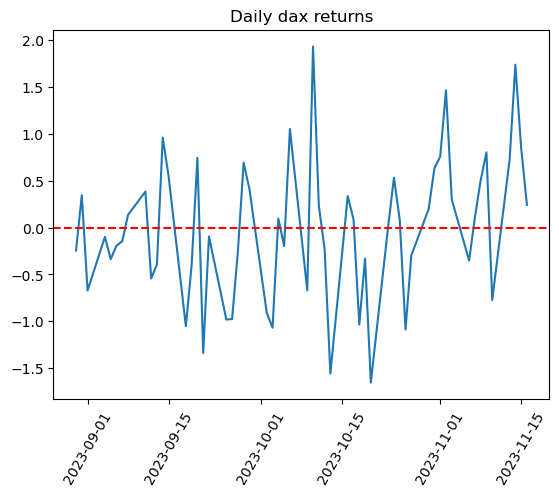

In [3]:
import matplotlib.pyplot as plt
daxdataplot = daxdata.iloc[1015:,]
plt.plot(daxdataplot['LogRetLag1'])
plt.axhline(0, color='red', linestyle='--', label='Level 0')
plt.title("Daily dax returns")
plt.xticks(rotation=60)

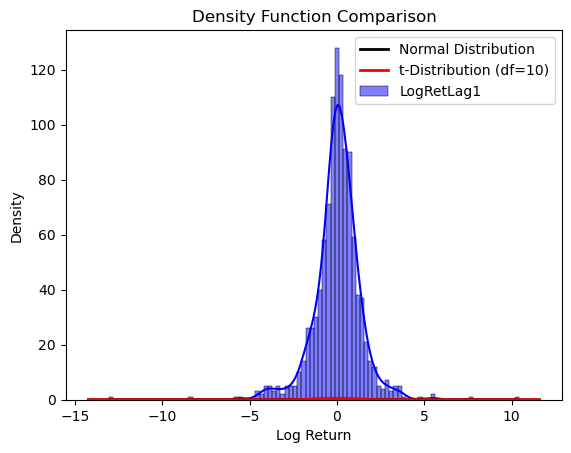

In [4]:
import seaborn as sns
from scipy.stats import norm, t

# Assuming df is your DataFrame
log_ret_lag1 = daxdata['LogRetLag1'].dropna()

# Plot the density function of LogRetLag1
sns.histplot(log_ret_lag1, kde=True, label='LogRetLag1', color='blue')

# Plot the density function of a normal distribution with the same mean and standard deviation
mu, std = 0, log_ret_lag1.std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')

df_t = len(log_ret_lag1) - 1  # degrees of freedom
df_t2 = 10 # used in Arch documentation
p_t = t.pdf(x, df_t)
plt.plot(x, p_t, 'r', linewidth=2, label=f't-Distribution (df={df_t2})')

# Add labels and title
plt.title('Density Function Comparison')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()



Open Question: Underlying Normal Distribution seems pretty appropriate, t distribution does not --> why? (According to literature, t should be considered)
Different approach: GARCH(1,1) with leptokurtic error distribution

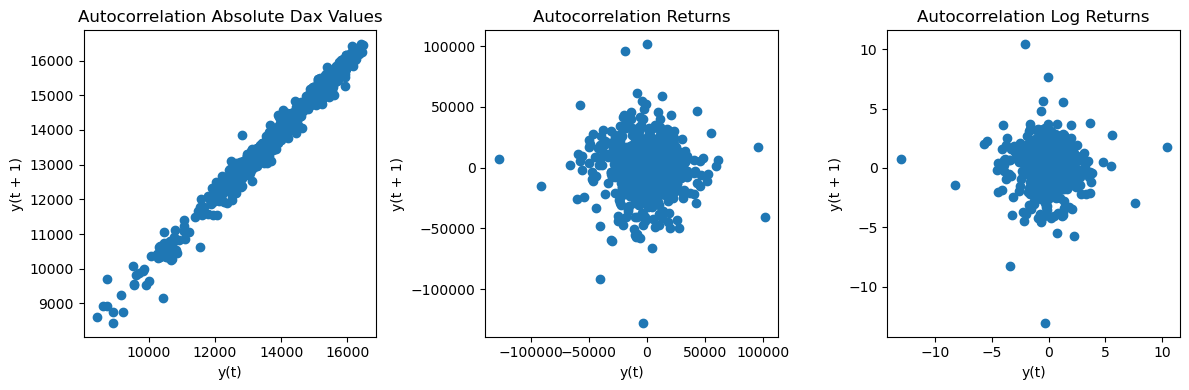

In [5]:
# Check Autocorrelation
from pandas.plotting import lag_plot
from matplotlib import pyplot

# Create a figure with two subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

lag_plot(daxdata['Close'], ax=axes[0])
axes[0].set_title('Autocorrelation Absolute Dax Values')

lag_plot(daxdata['RetLag1'], ax=axes[1])
axes[1].set_title('Autocorrelation Returns')


lag_plot(daxdata['LogRetLag1'], ax=axes[2])
axes[2].set_title('Autocorrelation Log Returns')

# Adjust layout
plt.tight_layout()

Autocorrelation clear to see, but by taking the returns, no autocorrelation anymore
Proven by literature: The findings confirm that the DAX returns are not serially correlated up to lag 20 (https://opus.uni-hohenheim.de/volltexte/2017/1307/pdf/Thesis_Final_Harald_Weiss.pdf


### GARCH-Model
GARCH(1,1):<br>
$R_t = ε_t$ <br>
$ε_t = \sqrt{h_t} u_t$ and $u_t ∼ N(0, 1)$ <br>
$h_t = α_0 + α_1R_{t-1}^2 + β_1h_{t−1}$

In [6]:
from arch import arch_model

# basic GARCH(1,1)
model_garch11 = arch_model(
    daxdata['LogRetLag1'], mean='constant', vol='GARCH', p=1, q=1).fit()

# compare to GARCH(1,2) via AIC, BIC
model_garch12 = arch_model(
    daxdata['LogRetLag1'], mean='constant', vol='GARCH', p=1, q=2).fit()

# compare to GARCH(1,1) with zero constant
model_garch_zero = arch_model(
    daxdata['LogRetLag1'], mean='zero', vol='GARCH', p=1, q=1).fit()

# compare to GARCH(1,1) with t distribution
model_garch_t = arch_model(
    daxdata['LogRetLag1'], mean='constant', vol='GARCH', p=1, q=1).fit()

# compare to GARCH(1,1) with zero constant and t distribution
model_garch_zero_t = arch_model(
    daxdata['LogRetLag1'], mean='zero', vol='GARCH', dist="StudentsT", p=1, q=1).fit()


# extract AIC and BIC for each model
results = {
    "Model": ["GARCH(1,1)", "GARCH(1,2)", "GARCH(1,1) with mean zero", "GARCH(1,1) with t dist", "GARCH(1,1) with mean zero and t dist"],
    "AIC": [model_garch11.aic, model_garch12.aic, model_garch_zero.aic, model_garch_t.aic, model_garch_zero_t.aic],
    "BIC": [model_garch11.bic, model_garch12.bic, model_garch_zero.bic, model_garch_t.bic, model_garch_zero_t.bic]
}

# create a DataFrame
comparison_df = pd.DataFrame(results)
comparison_df

Iteration:      1,   Func. Count:      6,   Neg. LLF: 22095.519532545222
Iteration:      2,   Func. Count:     15,   Neg. LLF: 394419173641.23895
Iteration:      3,   Func. Count:     23,   Neg. LLF: 2127.953895303822
Iteration:      4,   Func. Count:     30,   Neg. LLF: 2127.4366284581383
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1685.417436495446
Iteration:      6,   Func. Count:     42,   Neg. LLF: 1683.071280548726
Iteration:      7,   Func. Count:     47,   Neg. LLF: 1683.0570625269606
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1683.0567229152218
Iteration:      9,   Func. Count:     57,   Neg. LLF: 1683.0566809581524
Iteration:     10,   Func. Count:     62,   Neg. LLF: 1683.056659510828
Iteration:     11,   Func. Count:     67,   Neg. LLF: 1683.0566589478128
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1683.0566589478128
            Iterations: 11
            Function evaluations: 67
            Gradient evaluat

,Model,AIC,BIC
0,"GARCH(1,1)",3374.113318,3394.022443
1,"GARCH(1,2)",3375.460697,3400.347104
2,"GARCH(1,1) with mean zero",3376.382351,3391.314195
3,"GARCH(1,1) with t dist",3374.113318,3394.022443
4,"GARCH(1,1) with mean zero and t dist",3272.536856,3292.445982


In [8]:
# forecasting quantiles of model_garch_zero 

import pandas as pd
from scipy.stats import norm

forecast = model_garch_zero.forecast(horizon=5, reindex=False)
forecast_variances = forecast.variance

# Define the quantiles
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

# Create DataFrame storing quantile forecasts in submission form
quantile_forecasts = pd.DataFrame({
    "target": "DAX",
    "horizon": [str(i) + " day" for i in (1, 2, 5, 6, 7)],
    "variance": forecast_variances.iloc[0].values})

# Calculate quantiles for each variance
for q in quantiles:
    quantile_forecasts[f'q{q}'] = quantile_forecasts['variance'].apply(
        lambda x: norm.ppf(q, loc=0, scale=np.sqrt(x)))
    
last_date = daxdata.index[-1]
first_index_date = last_date + pd.Timedelta(days=1)
quantile_forecasts.index = pd.date_range(
        start=first_index_date, periods=5, freq='B')

date_st = (datetime.today().strftime('%Y-%m-%d'))
quantile_forecasts.insert(0, 'forecast_date', date_st)
quantile_forecasts = quantile_forecasts.drop(columns={'variance'})


In [10]:
# forecast of quantiles with model_garch_zero_t 

# get required paramters
coeff = model_garch_zero_t.params

# calculate variance for last timestamp 
h_0 = model_garch_zero_t.conditional_volatility[-1]                                                             

# more approximate to say residuals instead of logreturnforecast
def simulate_GARCH(h, coeff, daxdata, h_0):

    # initialize parameters
    last_return = daxdata.iloc[-1].loc['LogRetLag1']
    np.random.seed(100)
    white_noise = np.random.standard_t(df=5, size=h)  
    resid = np.zeros_like(white_noise)
    resid[0] = float(last_return)
    variance = np.zeros_like(white_noise)
    variance[0] = h_0

    for t in range(1, h):
        # Simulate the variance (sigma squared)
        variance[t] = coeff[0] + coeff[1] * resid[t-1]**2 + coeff[2] * variance[t-1]
        # Simulate residuals 
        resid[t] = np.sqrt(variance[t]) * white_noise[t]

    dax_forecasts = pd.DataFrame({
        "horizon": [str(i) + " day" for i in (0, 1, 2, 5, 6, 7)], 
        "variance": variance, 
        "residuals": resid})
    
    first_index_date = daxdata.index[-1] 
    dax_forecasts.index = pd.date_range(
        start=first_index_date, periods=h, freq='B')
    
    return dax_forecasts

forecasts = simulate_GARCH(6, coeff, daxdata, h_0)
forecasts

,horizon,variance,residuals
2023-11-16,0 day,1.070387,0.243797
2023-11-17,1 day,0.960800,0.501094
2023-11-20,2 day,0.897558,0.341286
2023-11-21,5 day,0.825041,-0.683072
2023-11-22,6 day,0.815990,-0.385994
2023-11-23,7 day,0.761791,-0.952833


### Calculate Quantile Forecasts
Formula:
$ \hat{Q}_{q,t+h} = - t_{5, 1-q}*\sqrt{\hat{h}_{t+h}} $

In [11]:
from scipy.stats import t

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

def calculate_Q_hat(row, quantile):
    return  -(t.ppf((1-quantile), 5) * np.sqrt(row['variance']))

for q in quantiles:
    forecasts[f'q{q}'] = forecasts.apply(calculate_Q_hat, quantile=q, axis=1)
forecasts

,horizon,variance,residuals,q0.025,q0.25,q0.5,q0.75,q0.975
2023-11-16,0 day,1.070387,0.243797,-2.659512,-0.751827,-7.217340e-17,0.751827,2.659512
2023-11-17,1 day,0.960800,0.501094,-2.519694,-0.712301,-6.837906e-17,0.712301,2.519694
2023-11-20,2 day,0.897558,0.341286,-2.435357,-0.688460,-6.609032e-17,0.688460,2.435357
2023-11-21,5 day,0.825041,-0.683072,-2.334905,-0.660063,-6.336428e-17,0.660063,2.334905
2023-11-22,6 day,0.815990,-0.385994,-2.322063,-0.656432,-6.301576e-17,0.656432,2.322063
2023-11-23,7 day,0.761791,-0.952833,-2.243621,-0.634257,-6.088703e-17,0.634257,2.243621


### Specification of the Conditional Mean
Specifying the variance equation for the GARCH models requires the identification 
of an appropriate model for the conditional mean. <br>

Diebold (1988) demonstrates that Bartlett’s confidence bands are overly conservative in the 
presence of ARCH effects --> Use of Barlett’s original formula can lead to 
a misspecification of the ARMA process for the conditional mean, since the original formula 
underestimates the variances of the sample autocorrelations.<br>
Thus, the corrected 95% confidence interval B(τ) for the sample autocorrelation 
$\hat{p}(τ)$ is calculated based on Diebold’s formula: <br>
<br>
$B(τ) = 0 ± 1.96 \sqrt{S(τ)}$ <br>
$S(τ) = 1/T* (1 + \frac{\hat{y}(τ)}{\hat{σ^4}})$

* S(τ): variance of sample autocorrelations
* $\hat{y}(τ)$, $\hat{p}(τ)$: estimated autocovariance of the squared DAX returns
* $\hat{σ^4}$: squared sample variance of the DAX returns

Dax returns not correlated anymore (also proven by paper, see link), means <br>
$E[r_t |I_{t−1}] = µ$

In [12]:
# Try out ARX model 
from arch.univariate import ARX
ar = ARX(daxdata['LogRetLag1'], lags=[1])
print(ar.fit().summary())
# p-Values not significant --> Stick to constant mean

                     AR - Constant Variance Model Results                     
Dep. Variable:             LogRetLag1   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:          Constant Variance   Log-Likelihood:               -1873.76
Distribution:                  Normal   AIC:                           3753.53
Method:            Maximum Likelihood   BIC:                           3768.46
                                        No. Observations:                 1071
Date:                Fri, Nov 17 2023   Df Residuals:                     1069
Time:                        08:26:25   Df Model:                            2
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------------------------
Const             0.0260  4.272e-02      0.610

# Next steps
Mean model specifications: autoregressive mean: model the mean as an autoregressive (AR) process 
Conclusion: does not make sense --> No AR(p) model for mean

In [14]:
from statsmodels.tsa.ar_model import AutoReg  
model = AutoReg(daxdata['LogRetLag1'], lags=1).fit()
model.summary()

c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             LogRetLag1   No. Observations:                 1072
Model:                     AutoReg(1)   Log Likelihood               -1873.765
Method:               Conditional MLE   S.D. of innovations              1.392
Date:                Fri, 17 Nov 2023   AIC                           3753.529
Time:                        08:26:54   BIC                           3768.458
Sample:                             1   HQIC                          3759.184
                                 1072                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0260      0.043      0.612      0.540      -0.057       0.109
LogRetLag1.L1    -0.0244      0.031     -0.798      0.425      -0.084       0.035
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -41.0487           +0.0000j           41.0487            0.5000
-----------------------------------------------------------------------------
"""